# Chocolate Chip Cookies vs Raisin Cookies Image Classification

Our goal is to train a model that saves humanity for the repeated tragedy:

![cookies](../images/choco_raisin_meme.jpg)

We train a chocalate chip cookies vs raisin cookies image classifier with data obtained from [DuckDuckGo](http://duckduckgo.com/) image search. We obtained over 85% accruacy in the validation set. Train-validation split and label distribution are as follows:

```
- images
    - train
        -chocolate chip (572 images)
        - raisin (570 images)
    - valid
        -chocolate chip (144 images)
        - raisin (140 images)
```

## Installs and Imports

In [1]:
#install fastai2
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 727kB 7.7MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 1.2MB 37.2MB/s 
     |████████████████████████████████| 194kB 50.9MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 12.8MB 248kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [2]:
#imports
from fastbook import *
from fastai.vision.widgets import *

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Dataset from Repository

Get dataset from [cstorm125/choco-raisin](https://github.com/cstorm125/choco-raisin). Images are downloaded with `download_images.ipynb` and split with `train_valid_splits.ipynb`.

In [3]:
!npx degit github:cstorm125/choco-raisin#main choco-raisin

npx: installed 1 in 1.762s
> cloned cstorm125/choco-raisin#main to choco-raisin


In [4]:
path = Path('choco-raisin/images')

## From Data to DataLoaders

Construct dataloader from images. We decided to do squish resizing to prevent mistaken cropping of larger images (cropping part of the image where there are neither chocolate chips nor raisins).

In [13]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    #two choices for resizing and rationale
    #squishing to prevent cropping places without chips/raisins
    item_tfms=Resize(512, method=ResizeMethod.Squish), 
    # #cropping to preserve image quality; tried and doesn't work - peaked at 0.85 val acc
    # item_tfms=RandomResizedCrop(512),
    batch_tfms=aug_transforms(size=512), #standard fastai augmentation at size 512
    )
dls = dblock.dataloaders(path, bs=64) #batch size = 64

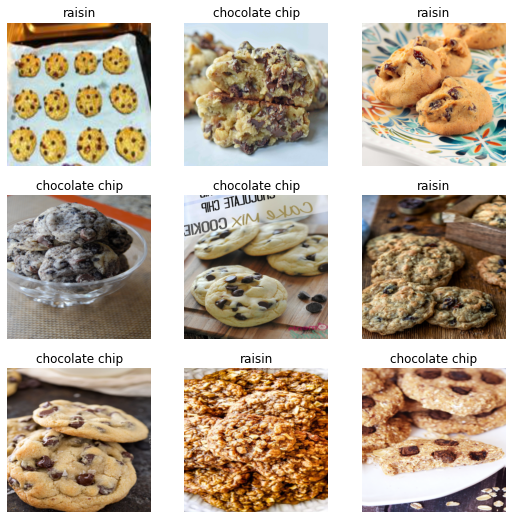

In [18]:
dls.train.show_batch(max_n=9, nrows=3)

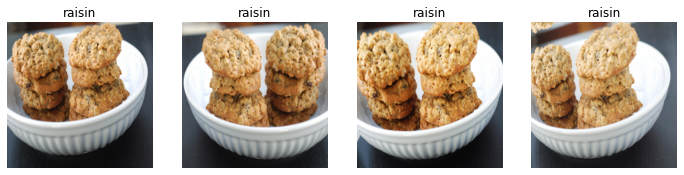

In [19]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Train Model

We use `resnet34` to train the model with validation accuracy as the metric.

In [71]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy])

We find that `1e-3` seems like a good base learning rate for 1cycle policy.

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.002511886414140463)

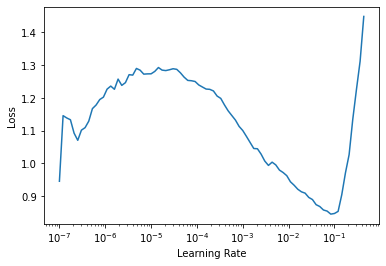

In [21]:
learn.lr_find()

We train for 1 epoch with only the head layer and 5 epochs with all layers. Don't worry about `train_loss` being lower than `valid_loss`; as long as `valid_loss` (and `accuracy) continues to improve, we should keep training.

In [72]:
learn.fine_tune(epochs=5,
          base_lr=1e-3, #base lr; when unfrozen base_lr/2
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with base_lr/lr_mult
          pct_start=0.3, #start decreasing lr at 
          div=4.0, #max lr = base_lr * div
          )

epoch,train_loss,valid_loss,accuracy,time
0,0.846216,0.455354,0.792253,01:08


epoch,train_loss,valid_loss,accuracy,time
0,0.508421,0.356103,0.823944,01:13
1,0.428704,0.352050,0.862676,01:12
2,0.350289,0.400795,0.845070,01:12
3,0.287474,0.353043,0.862676,01:12
4,0.240464,0.319742,0.880282,01:14


Train and validation losses.

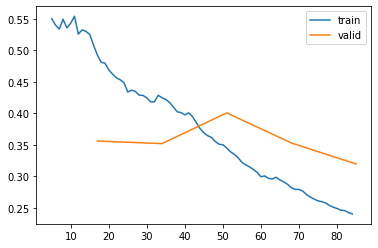

In [73]:
learn.recorder.plot_loss()

Learning rate schedule, starting from base learning rate to max learning rate then gradually decreasing to zero.

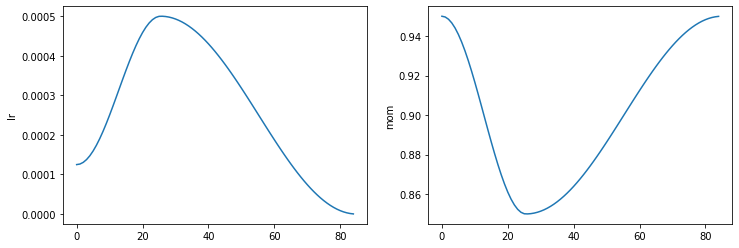

In [74]:
learn.recorder.plot_sched()

Save the model for later uses.

In [75]:
learn.save('resnet34_finetune1e3_5p');
learn.load('resnet34_finetune1e3_5p');

Create fastai interpretation object to check validation results.

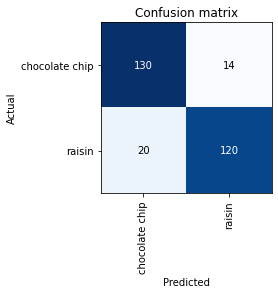

In [76]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Images with top losses, aka those that the model was most confident about but got it wrong.

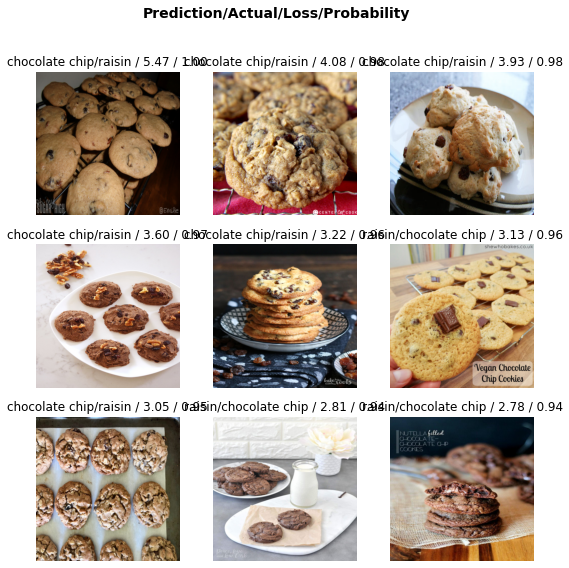

In [77]:
interp.plot_top_losses(9, nrows=3)

Random batches of results in validation set (above - ground truth; below - prediction)

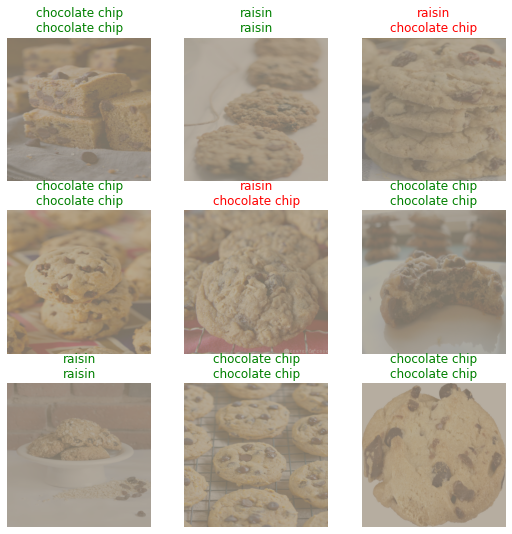

In [78]:
learn.show_results()

## Turning Your Model into an Online Application

### Using the Model for Inference

Export fastai `learner` for inference.

In [55]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [56]:
learn_inf = load_learner(path/'export.pkl')

In [57]:
#predict a raisin image
learn_inf.predict('choco-raisin/images/valid/raisin/00000007.jpg')

('raisin', tensor(1), tensor([0.3593, 0.6407]))

In [61]:
#predict a chocolate chip image
learn_inf.predict('choco-raisin/images/valid/chocolate chip/00000003.jpg')

('chocolate chip', tensor(0), tensor([9.9955e-01, 4.5341e-04]))

In [60]:
learn_inf.dls.vocab

['chocolate chip', 'raisin']

### Creating a Notebook App from the Model

Run inference app in notebook.

In [62]:
#upload button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [63]:
#image
img = PILImage.create(btn_upload.data[-1])

In [64]:
#display as 128 * 128
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [65]:
#get prediction
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: chocolate chip; Probability: 0.9988')

### Putting Together a Notebook App

In [69]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

In [70]:
VBox([widgets.Label('Select your cookies!'), 
      btn_upload, btn_run, out_pl, lbl_pred])